In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image

In [0]:
!unzip 'images.zip'

### O problema

**Descrição do problema**

"Para avaliar o impacto da mudança climática na flora e fauna da Terra, é vital quantificar o quanto atividades humanas como exploração madereira, mineração, e agricultura estão impactando nossas reservas naturais protegidas. Pesquisadores no México criaram o projeto VIGIA, que busca construir um sistema autônomo de vigilância de áreas protegidas. O primeiro passo neste esforço é a habiilidade de reconhecer a vegetação dentro de áreas protegidas. Nesta competição, você recebe o objetivo de criar um algoritmo capaz de identificar tipos de cactus em imagens aéreas."

### Informações sobre o dataset

O dataset é composto por imagens de tamanho 32x32 pixels de fotos áreas de cactos colunares. Estão disponíveis 17.500 imagens.

### Carregando os dados

In [0]:
IMAGES_FOLDER = 'images'

In [0]:
# Carrega o dataset
df = pd.read_csv('train.csv')

In [21]:
# Mostra os primeiros elementos do dataset
df.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [22]:
df.shape

(17500, 2)

### Ajustando o dataset

In [0]:
# Converte a coluna has_cactus em tipo string
df['has_cactus'] = df['has_cactus'].astype('str')

### Visualizando os dados

In [0]:
# Função auxilar que retorna uma representação de string de has_cactus
def hasCactusParser(has_cactus):
    if has_cactus == '1':
        return 'Cacto'
    return 'Não é cacto'

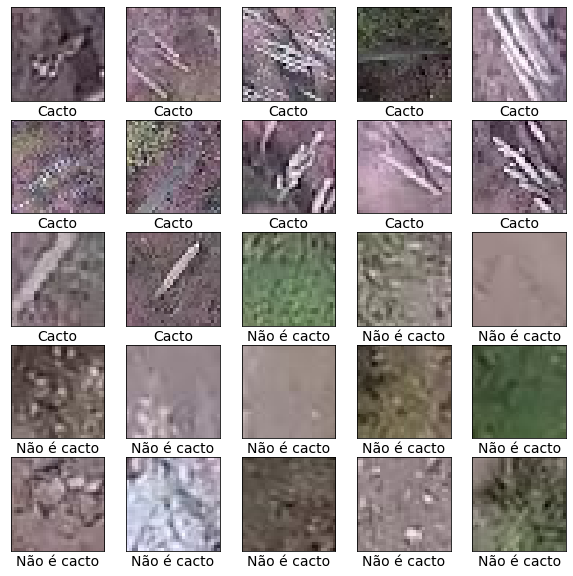

In [251]:
# Visualizando algumas imagens
plt.figure(figsize=(10,10))
cactos =  df[df['has_cactus'] == '1']
nao_cactos =  df[df['has_cactus'] == '0']
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    row_index = None
    image_data = None
    label = None
    if i < 12:
      row_index = random.randint(0, len(cactos))
      image_data = Image.open(IMAGES_FOLDER + '/' + cactos['id'].iloc[row_index])
      label = cactos['has_cactus'].iloc[row_index]
    else:
      row_index = random.randint(0, len(nao_cactos))
      image_data = Image.open(IMAGES_FOLDER + '/' + nao_cactos['id'].iloc[row_index])
      label = nao_cactos['has_cactus'].iloc[row_index]

    plt.imshow(image_data, cmap=plt.cm.binary)
    plt.xlabel(hasCactusParser(label), fontsize=14)
plt.show()

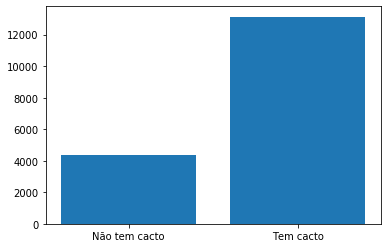

In [26]:
# Distribuição dos dados
graph = plt.bar(x = ['Não tem cacto', 'Tem cacto'], height=df.groupby(['has_cactus'])['has_cactus'].count())
plt.show()

### Separando dados de treino e teste

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
# Separa o dataset em dados de treino, teste e validação
train, test = train_test_split(df, test_size=0.3, random_state=42, stratify=df['has_cactus'])
train, val = train_test_split(train, test_size=0.2, random_state=42, stratify=train['has_cactus'])

### Parâmetros de treino

In [0]:
BATCH_SIZE = 64
EPOCHS = 100

### Utilizando Image Data Generator para criar novas imagens

In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [0]:
train_generator_ = ImageDataGenerator(
    rescale=1/255,
    horizontal_flip=True,
    vertical_flip=True
)

val_generator = ImageDataGenerator(
    rescale=1/255,
)

test_generator_ = ImageDataGenerator(
)

In [112]:
train_generator = train_generator_.flow_from_dataframe(dataframe=train,
                                                       directory=IMAGES_FOLDER,
                                                       x_col='id',
                                                       y_col='has_cactus',
                                                       class_mode='binary',
                                                       target_size=(32, 32), batch_size=BATCH_SIZE)

validation_generator = val_generator.flow_from_dataframe(dataframe=val,
                                                       directory=IMAGES_FOLDER,
                                                       x_col='id',
                                                       y_col='has_cactus',
                                                       class_mode='binary',
                                                       target_size=(32, 32), batch_size=BATCH_SIZE)

test_generator = test_generator_.flow_from_dataframe(dataframe=test,
                                                     directory=IMAGES_FOLDER,
                                                     x_col='id',
                                                     class_mode=None,
                                                     shuffle=False,
                                                     target_size=(32, 32))

Found 9800 validated image filenames belonging to 2 classes.
Found 2450 validated image filenames belonging to 2 classes.
Found 5250 validated image filenames.


### Visualizando o generator

In [0]:
image_index = random.randint(0, len(train))
imagem_original = np.array(Image.open(IMAGES_FOLDER + '/' + train['id'].iloc[image_index]))
imagem_label = np.array([train['has_cactus'].iloc[image_index]])

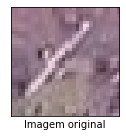

In [221]:
plt.figure(figsize=(2, 2))
plt.imshow(imagem_original)
plt.xticks([])
plt.yticks([])
plt.xlabel('Imagem original')
plt.show()

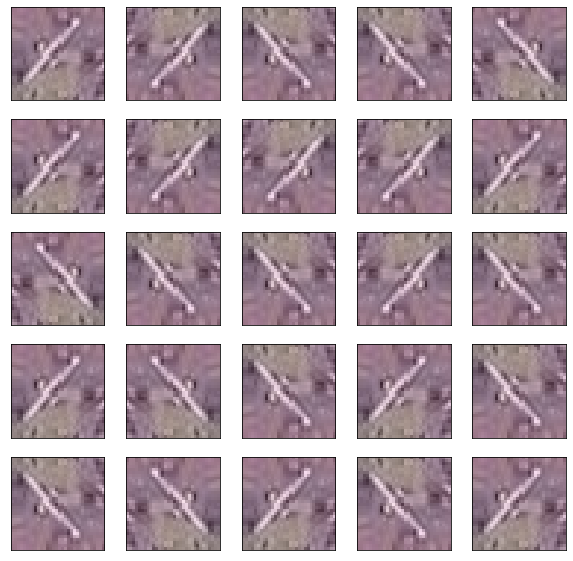

In [222]:
# Visualizando algumas imagens
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    image_data = None
    for x, y in train_generator_.flow(np.array([imagem_original]), imagem_label, batch_size=1):
        image_data = x.reshape(32, 32, 3)
        break
    
    plt.imshow(image_data, cmap=plt.cm.binary)
plt.show()

### Criando o modelo

In [0]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Activation, Dense, Flatten, Dropout
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model

In [37]:
model = Sequential([
    Conv2D(filters=32, kernel_size=5, kernel_initializer='he_uniform', strides=1, padding='same', activation='relu', input_shape=(32, 32, 3)),
    MaxPool2D((2, 2)),
    Conv2D(filters=64, kernel_size=3, kernel_initializer='he_uniform', strides=1, padding='same', activation='relu'),
    Conv2D(filters=64, kernel_size=3, kernel_initializer='he_uniform', strides=1, padding='same', activation='relu'),
    MaxPool2D((2, 2)),
    Conv2D(filters=128, kernel_size=3, kernel_initializer='he_uniform', strides=1, padding='same', activation='relu'),
    Conv2D(filters=128, kernel_size=3, kernel_initializer='he_uniform', strides=1, padding='same', activation='relu'),
    MaxPool2D((2, 2)),
    Conv2D(filters=256, kernel_size=3, kernel_initializer='he_uniform', strides=1, padding='same', activation='relu'),
    Conv2D(filters=256, kernel_size=3, kernel_initializer='he_uniform', strides=1, padding='same', activation='relu'),
    MaxPool2D((2, 2)),
    Flatten(),
    Dense(units=128, kernel_initializer='he_uniform', activation='relu'),
    Dropout(0.5),
    Dense(units=64, activation='relu'),
    Dropout(0.5),
    Dense(units=1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


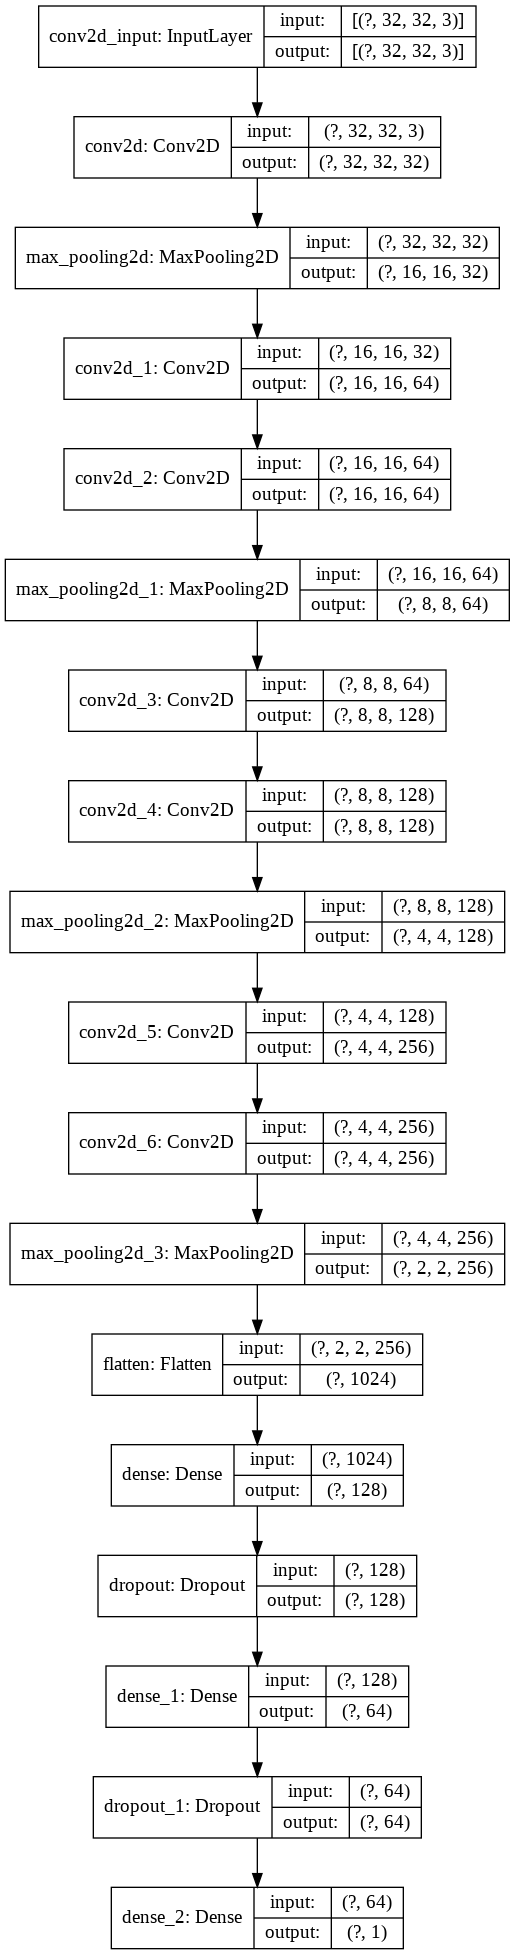

In [38]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [39]:
train.shape, val.shape, test.shape

((9800, 2), (2450, 2), (5250, 2))

### Treinando o modelo

In [40]:
model.fit_generator(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS, verbose=1)

Epoch 1/100
154/154 [==============================] - 11s 68ms/step - loss: 0.3479 - acc: 0.8254 - val_loss: 0.2391 - val_acc: 0.9004
Epoch 2/100
154/154 [==============================] - 6s 38ms/step - loss: 0.1520 - acc: 0.9479 - val_loss: 0.1358 - val_acc: 0.9576
Epoch 3/100
154/154 [==============================] - 6s 38ms/step - loss: 0.0997 - acc: 0.9664 - val_loss: 0.1176 - val_acc: 0.9641
Epoch 4/100
154/154 [==============================] - 6s 38ms/step - loss: 0.0901 - acc: 0.9676 - val_loss: 0.0745 - val_acc: 0.9776
Epoch 5/100
154/154 [==============================] - 6s 39ms/step - loss: 0.0651 - acc: 0.9804 - val_loss: 0.0507 - val_acc: 0.9841
Epoch 6/100
154/154 [==============================] - 6s 39ms/step - loss: 0.0625 - acc: 0.9781 - val_loss: 0.0716 - val_acc: 0.9771
Epoch 7/100
154/154 [==============================] - 6s 39ms/step - loss: 0.0599 - acc: 0.9802 - val_loss: 0.0748 - val_acc: 0.9751
Epoch 8/100
154/154 [==============================] - 6s 38m

### Resultados do treino

In [0]:
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title('Acurácia do Modelo')
plt.ylabel('acurácia')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Loss do Modelo')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Testando o modelo

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [0]:
pred = model.predict_classes(test_generator, batch_size=None)
pred = pred.astype('str')

In [139]:
print(classification_report(test['has_cactus'], pred))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      1309
           1       1.00      0.95      0.97      3941

    accuracy                           0.96      5250
   macro avg       0.94      0.97      0.95      5250
weighted avg       0.97      0.96      0.96      5250



### Resultados

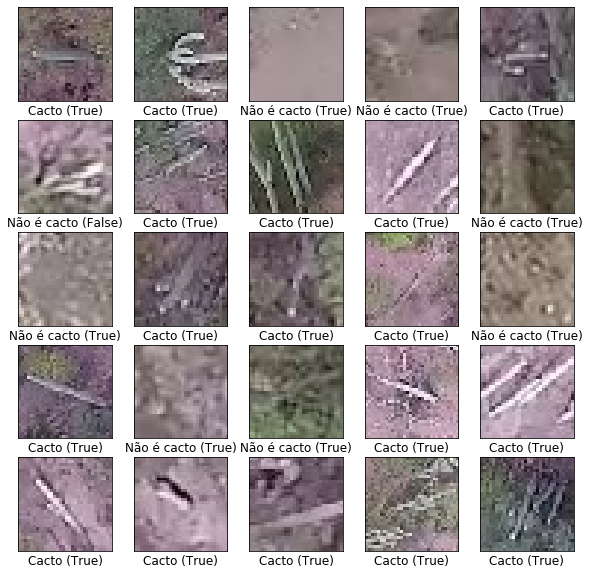

In [148]:
# Visualizando algumas imagens
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    row_index = random.randint(0, len(test))
    image_data = np.array(Image.open(IMAGES_FOLDER + '/' + test['id'].iloc[row_index]))
    image_label = test['has_cactus'].iloc[row_index]
    
    plt.imshow(image_data, cmap=plt.cm.binary)
    label = '{} ({})'.format(hasCactusParser(pred[row_index]), (pred[row_index] == test['has_cactus'].iloc[row_index])[0])
    plt.xlabel(label, fontsize=12)
plt.show()